# Random Forest Classifier

## Load data

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv('~/R Projects/rfApp/streamlit_app/data/dev/train.csv', header=0, encoding = "utf8", index_col=False)
X = df.iloc[:,1:3].to_numpy()
y = df.iloc[:,0].to_numpy()

### Scatter Plot

Text(0.5, 1.0, '数据分布散点图')

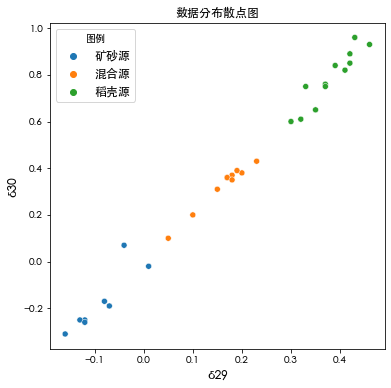

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC'] # Set font for Chinese

fig, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = df, x = "x1", y="x2", hue = "y")
plt.legend(title= "图例", fontsize=12)
plt.xlabel("δ29", fontsize=12)
plt.ylabel("δ30", fontsize=12)
plt.title("数据分布散点图", fontsize=12)


## Split for training and testing

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [4]:
X_train.shape, y_train.shape

((21, 2), (21,))

In [5]:
X_test.shape, y_test.shape

((9, 2), (9,))

## Make classifier object

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

## Model evaluation

In [7]:
from sklearn.metrics import get_scorer_names
scores = get_scorer_names()

In [8]:
from sklearn.model_selection import cross_validate

# Precision: tp/(tp+fp)
# recall: tp/(tp+fn)
# accuracy: (tp+tn)/(tp+tn+fp+fn)
# f1: 2*precision*recall/(precision+recall)

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']
scores = cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scoring)

In [9]:
sorted(scores.keys())
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_precision_macro,test_recall_macro,test_accuracy,test_f1_macro
0,0.043799,0.003404,0.833333,0.833333,0.8,0.777778
1,0.040647,0.003103,1.000000,1.000000,1.0,1.000000
2,0.041274,0.003083,1.000000,1.000000,1.0,1.000000
3,0.040999,0.003071,1.000000,1.000000,1.0,1.000000
4,0.041284,0.003051,1.000000,1.000000,1.0,1.000000


> High accuracy, precision, recall, and F1

## Model training

In [8]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
y_total = pd.DataFrame(np.concatenate((y_pred.reshape(-1,1),y_score),axis=1),columns = ["预测","混合源","矿砂源","稻壳源"])

In [10]:
y_total

,预测,混合源,矿砂源,稻壳源
0,稻壳源,0.0,0.0,1.0
1,稻壳源,0.0,0.0,1.0
2,混合源,1.0,0.0,0.0
3,矿砂源,0.35,0.65,0.0
4,混合源,0.99,0.0,0.01
5,混合源,0.99,0.0,0.01
6,矿砂源,0.0,1.0,0.0
7,混合源,0.99,0.0,0.01
8,混合源,1.0,0.0,0.0


In [13]:
pd.DataFrame({'pred':y_pred,'true':y_test}).head()

,pred,true
0,稻壳源,稻壳源
1,稻壳源,稻壳源
2,混合源,混合源
3,矿砂源,矿砂源
4,混合源,混合源


> Accurate predictions in the testing dataset

### Save the model

In [14]:
from datetime import datetime
from joblib import dump, load

current = datetime.today()
filename = "model/model_"+current.strftime("%m-%d-%Y-%H%M%S")+".joblib"

dump(clf,filename)
clf2 = load(filename)

## ROC-AUC Analysis

In [15]:
from itertools import combinations

pair_list = list(combinations(np.unique(y_test),2))
print(pair_list)

[('混合源', '矿砂源'), ('混合源', '稻壳源'), ('矿砂源', '稻壳源')]


In [16]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train) # The fitting process involves learning how many labels are there and their names
y_onehot_test = label_binarizer.transform(y_test) # transform true y labels from the test set

In [17]:
target_names = label_binarizer.classes_
target_names

array(['混合源', '矿砂源', '稻壳源'], dtype='<U3')

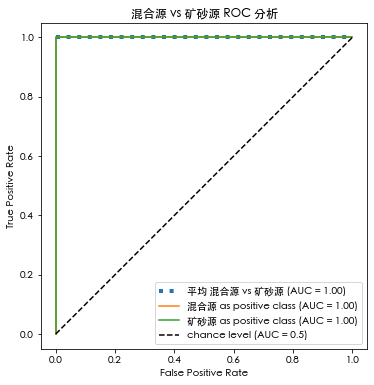

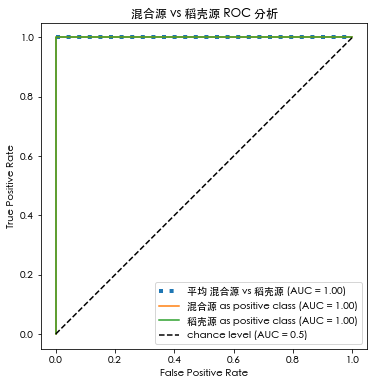

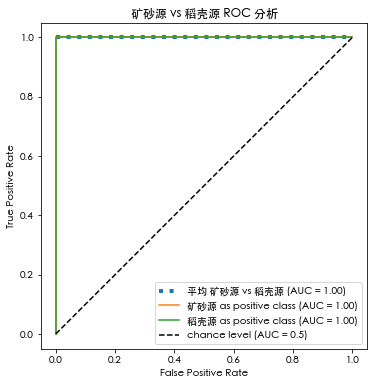

Macro-averaged One-vs-One ROC AUC score:
1.00


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay

pair_scores = []
mean_tpr = dict()

# Iterate through all pairs
for ix, (label_a, label_b) in enumerate(pair_list): # label a: first in the pair, label b: second in the pair

    a_mask = y_test == label_a # All y_tests that are 1 with label a
    b_mask = y_test == label_b # All y_tests that are 1 with label b
    ab_mask = np.logical_or(a_mask, b_mask) # All y_tests that are 1 for either a or b; remove the cases when c is true

    a_true = a_mask[ab_mask] # Remove entries when both a and b are 0
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0] # Index of label a class
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0] # Index of label b class

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a]) # Get fpr and tpr for a
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b]) # Get fpr and tpr for b
    
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    mean_tpr[ix] = np.zeros_like(fpr_grid) # Macro averaging for 2 classes; ix: index for each pair
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score) # Append score for this pair

    fig, ax = plt.subplots(figsize=(6, 6))
    # Macro-averaged score
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"平均 {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    # Label a ROC
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    # Label b ROC
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_b} ROC 分析")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

### Plot all OvO Curves

In [21]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

In [22]:
macro_roc_auc_ovo

1.0

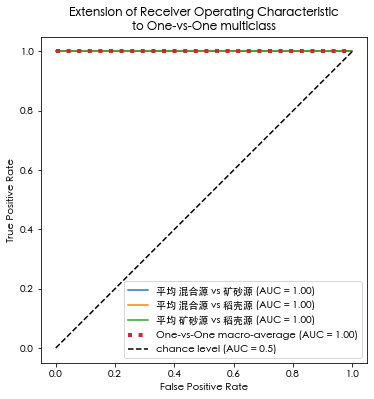

In [20]:
ovo_tpr = np.zeros_like(fpr_grid) # To compute average tpr for all pairs

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix] # Add to ovo_tpr 
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"平均 {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

## Decision Surface

In [21]:
clf.score(X_test,y_test)

1.0

/opt/homebrew/Caskroom/miniconda/base/envs/bio/lib/python3.11/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


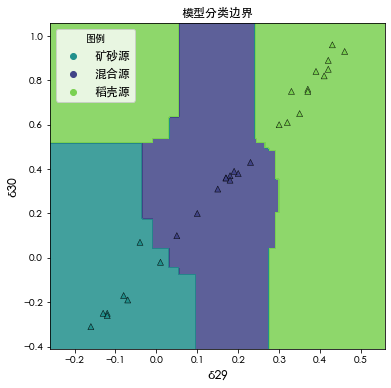

In [105]:
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

plot_step = 0.002
plot_step_coarser = 0.1
n_classes = 3

cmap = plt.colormaps["viridis"]
cmap = truncate_colormap(cmap,0.2,0.8)
sampleColor = cmap(np.linspace(0,1,n_classes))
cmap = colors.ListedColormap(sampleColor)


fig, ax = plt.subplots(figsize=(6, 6))

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)

# Make ordinal encoder
od = OrdinalEncoder().fit(y_train.reshape(-1, 1))

# Plot contour
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = od.transform(Z.reshape(-1,1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=.85)

# Plot points
# xx_coarser, yy_coarser = np.meshgrid(
#     np.arange(x_min, x_max, plot_step_coarser),
#     np.arange(y_min, y_max, plot_step_coarser),
# )
# Z_points_coarser = clf.predict(
#     np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
# )
# Z_points_coarser = od.transform(Z_points_coarser.reshape(-1, 1))
# Z_points_coarser = Z_points_coarser.reshape(xx_coarser.shape)
# cs_points = plt.scatter(
#     xx_coarser,
#     yy_coarser,
#     s=100,
#     c=Z_points_coarser,
#     cmap=cmap,
#     edgecolors="none",
# )

# Plot training points
# plt.scatter(
#     X[:, 0],
#     X[:, 1],
#     c = od.transform(y.reshape(-1,1)),
#     cmap=cmap,
#     edgecolor="black",
#     s=40,
# )

# matplotlib.cm.register_cmap("mycolormap", cmap)
# cpal = sns.color_palette("mycolormap", n_colors=3)
# cpal = np.array(cpal)[[1,0,2],:]

cpal = sampleColor[[1,0,2],0:3]

sns.scatterplot(data = df, x = "x1", y="x2", hue = "y", marker="^", edgecolor = "black", palette=cpal)
plt.legend(title= "图例", fontsize=12)
plt.xlabel("δ29", fontsize=12)
plt.ylabel("δ30", fontsize=12)
plt.title("模型分类边界", fontsize=12)
plt.grid(False)
plt.show()

## Test on mock data

In [12]:
mock_pred = pd.read_csv('~/R Projects/rfApp/streamlit_app/data/dev/mock_pred_noY.csv', header=0, encoding = "utf8", index_col=False)
# y_data = mock_pred.iloc[:,0].to_numpy()
x_data = mock_pred.iloc[:,0:2].to_numpy()

In [13]:
y_pred = clf.predict(x_data)
y_score = clf.predict_proba(x_data)
y_total = pd.DataFrame(np.concatenate((y_pred.reshape(-1,1),y_score,x_data),axis=1),columns = ["预测","混合源","矿砂源","稻壳源","x1","x2"])

In [14]:
y_total

,预测,混合源,矿砂源,稻壳源,x1,x2
0,混合源,1.0,0.0,0.0,0.120301,0.300968
1,混合源,0.92,0.02,0.06,0.06179,0.492627
2,混合源,0.97,0.0,0.03,0.172015,0.410474
3,混合源,0.97,0.0,0.03,0.123064,0.445471
4,混合源,0.94,0.06,0.0,0.141781,0.148358
5,混合源,1.0,0.0,0.0,0.156208,0.330221
6,混合源,1.0,0.0,0.0,0.187865,0.246684
7,混合源,1.0,0.0,0.0,0.171828,0.286788
8,混合源,1.0,0.0,0.0,0.12924,0.322132
9,混合源,1.0,0.0,0.0,0.161739,0.227963


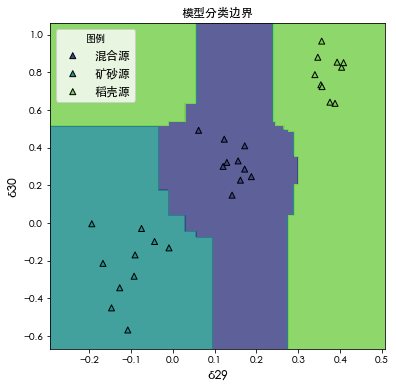

In [15]:
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.colors as colors

res = y_total
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        return new_cmap

plot_step = 0.002
n_classes = 3

labels = res.iloc[:,0].to_numpy()
X = res.iloc[:,4:6].to_numpy()

cmap = plt.colormaps["viridis"]
cmap = truncate_colormap(cmap,0.2,0.8)
sampleColor = cmap(np.linspace(0,1,n_classes))
cmap = colors.ListedColormap(sampleColor)

fig, ax = plt.subplots(figsize=(6, 6))

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)

# Make ordinal encoder
od = OrdinalEncoder().fit(labels.reshape(-1, 1))

# Plot contour
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = od.transform(Z.reshape(-1,1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=.85)

grouped = y_total.groupby("预测")
for (name, group), col in zip(grouped, sampleColor):
    ax.scatter(group["x1"], group["x2"], color=col, edgecolors = "black", marker="^", linestyle="", label=name)

# Hollow circles
# for (cat, group), col in zip(res.groupby("预测"), sampleColor):
#     ax.scatter(group.x1, group.x2, color = col, edgecolors= "black", facecolors="none", alpha=0.7, label=cat, marker="^")

plt.legend(title= "图例", fontsize=12)
plt.xlabel("δ29", fontsize=12)
plt.ylabel("δ30", fontsize=12)
plt.title("模型分类边界", fontsize=12)
plt.grid(False)

In [30]:
import itertools
add = pd.DataFrame({"x1":itertools.repeat(1,10)})
res1 = pd.concat([res,add])
for (cat,group) in res1.groupby("预测"):
    print(cat)

混合源
矿砂源
稻壳源


In [28]:
df.shape[0]

30